In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from dataclasses import dataclass, field
from abc import ABC, abstractmethod
import sys
sys.path.append("/home/armand/PhD/oc-guidance/models")
sys.path.append("/home/armand/PhD/oc-guidance/")
from guided_diffusion import create_model, create_model_and_diffusion, model_and_diffusion_defaults
from utils.degredations import build_degredation_model
from utils.functions import sigmoid, get_timesteps
# load and show test_image.png
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
from math import prod
from tqdm.auto import tqdm, trange
from torch.utils.data import DataLoader
from fff import FiberModel
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

INFO: Using pytorch backend
INFO: Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: NumExpr defaulting to 8 threads.


In [2]:
class FlowMatchingModel:
    def __init__(self, model: nn.Module):
        self.model = model

    def __call__(self, xt, y, t, **kwargs):
        """
        Forward pass through the flow matching model.
        :param xt: Current state (image).
        :param y: Condition (e.g., class label).
        :param t: Current timestep.
        :param kwargs: Additional arguments.
        :return: Estimated noise or flow at xt.
        """
        return self.model.density_model[0].get_vector_field_conditional(xt, t=t, c=y, **kwargs)

    @property
    def latent_dim(self):
        return self.model.density_model[0].hparams.latent_dim
    
    def decode(self, x, y):
        """
        Decode the latent representation to an image.
        :param x: Latent representation.
        :return: Decoded image.
        """
        return self.model.decode_lossless(x, y)

In [3]:
class Combine_fn(ABC):
    def __init__(self, gamma_t=None):
        self.gamma_t = gamma_t

    @abstractmethod
    def forward(self, xt, ut, t=None, **kwargs):
        pass

    def __call__(self, xt, ut, t=None, **kwargs):
        return self.forward(xt, ut, t=t, **kwargs)


class Additive(Combine_fn):
    def forward(self, xt, ut, t=None, **kwargs):
        gamma_t = self.gamma_t(t) if callable(self.gamma_t) else self.gamma_t
        return xt + (gamma_t * ut if gamma_t is not None else ut)

@dataclass
class NDTMConfig:
    N: int = 2  # Number of optimization steps
    gamma_t: float = 4.0  # u_t weight
    u_lr: float = 0.01  # learning rate for u_t
    combine_fn: str = "additive"  # Function to combine vfs
    w_vf_scheme: str = "zeros"  # Weighting scheme for vf
    w_control_scheme: str = "zeros"  # Weighting scheme for vf
    u_lr_scheduler: str = "linear"  # Learning rate scheduler for u_t
    init_control: str = "zero"  # Initialization scheme for u_t
    init_xT: str = "random" # Initialization scheme for x_T
    w_terminal: float = 50.0
    clip_images: bool = True  # If True, clip images
    clip_range: list = field(default_factory=lambda: [-1, 1])  # Range to clip images

class NDTM:
    def __init__(self, generative_model, subject_model, hparams):
        self.generative_model = generative_model
        self.subject_model = subject_model
        self.hparams = hparams
        self.F = self._get_combine_fn()

    def _get_combine_fn(self):
        if self.hparams.combine_fn == "additive":
            return Additive(gamma_t=self.hparams.gamma_t)

    def _get_vf_weight(self, scheme):
        if scheme == "zero":
            return torch.tensor([0.0], device=device)
        # also the "FM" scheme, since it has constant velocity
        elif scheme == "ones":
            return torch.tensor([1.0], device=device) * 1.e-4
        else:
            raise ValueError(f"Unknown scheme: {scheme}")

    def _get_control_weight(self, scheme):
        if scheme == "zero":
            return torch.tensor([0.0], device=device)
        elif scheme == "ones":
            return torch.tensor([1.0], device=device) * 1.e-4
        else:
            raise ValueError(f"Unknown scheme: {scheme}")

    def get_learning_rate(self, base_lr, current_step, total_steps):
        assert self.hparams.u_lr_scheduler in ["linear", "const"], \
            f"Unknown learning rate scheduler: {self.hparams.u_lr_scheduler}"
        
        if self.hparams.u_lr_scheduler == "linear":
            return base_lr * (1.0 - current_step / total_steps)
        else:  # const
            return base_lr

    def sample(self, x, y, num_timesteps=100, **kwargs):
        x_orig = x.clone()
        x = self.initialize(x, y, num_timesteps, **kwargs)
        y_0 = kwargs["y_0"]
        bs = x.size(0)
        xt = x
        xt_s = [xt.cpu()]
        x0_s = []
        uts = []        
        u_t = torch.zeros_like(xt)
        ts = torch.linspace(0, 1 - 1/num_timesteps, num_timesteps).to(x.device)
        
        pbar = tqdm(ts, desc="Sampling")
        for i, ti in enumerate(pbar):

            t = torch.ones(bs).to(x.device).long() * ti

            # Initialize control and the optimizer
            u_t = self.initialize_ut(u_t, i)
            ut_clone = u_t.clone().detach()
            ut_clone.requires_grad = True
            current_lr = self.get_learning_rate(self.hparams.u_lr, i, num_timesteps)
            optimizer = torch.optim.Adam([ut_clone], lr=current_lr)

            # Loss weightings
            w_terminal = self.hparams.w_terminal
            w_vf = self._get_vf_weight(self.hparams.w_vf_scheme)
            w_control = self._get_control_weight(self.hparams.w_control_scheme)
            
            ####################################################
            ############## Control Optimization ################
            ####################################################
            vt = self.generative_model(xt, y, t).detach()
            for _ in range(self.hparams.N):
                if callable(self.hparams.gamma_t):
                    gamma_t = self.hparams.gamma_t(t)
                else:
                    gamma_t = self.hparams.gamma_t
                if gamma_t == 0:
                    break
                # Guided state vector
                cxt = self.F(xt, ut_clone, t=t, **kwargs)

                # Unguided and guided noise estimates
                vt_control = self.generative_model(cxt, y, t)
                c_vf = w_vf * ((vt_control - vt) ** 2).reshape(bs, -1).sum(dim=1)
                # Control loss
                control_loss = (((self.F(xt, ut_clone, t=t, **kwargs) - xt) ** 2).reshape(bs, -1).sum(dim=1))
                c_control = w_control * control_loss * (gamma_t**2)

                # Terminal Cost
                # c_terminal = ((y_0 - self.subject_model(x0_pred)) ** 2).reshape(bs, -1).sum(dim=1)
                x0_pred = self.generative_model.decode(cxt - (1 - ti) * vt_control, y)
                if self.hparams.clip_images:
                    x0_pred = torch.clamp(x0_pred, self.hparams.clip_range[0], self.hparams.clip_range[1])
                c_terminal = torch.norm((y_0 - self.subject_model(x0_pred)), p=2).reshape(bs, -1).sum(dim=1)
                c_terminal = w_terminal * c_terminal

                # Aggregate Cost and optimize
                c_t = c_vf + c_control + c_terminal

                # print(
                #     f"Diffusion step: {ti} Terminal Loss: {c_terminal.mean().item()} "
                #     f"Control loss: {c_control.mean().item()} vf loss: {c_vf.mean().item()}"
                # )
                

                optimizer.zero_grad()
                c_t.sum().backward()
                optimizer.step()
            if self.hparams.N > 0 and gamma_t != 0:
                pbar.set_description(
                    f"Diffusion step: {ti} Terminal Loss: {c_terminal.mean().item()} "
                    f"Control loss: {c_control.mean().item()} vf loss: {c_vf.mean().item()}"
                )
            ###########################################
            ############## DDIM update ################
            ###########################################
            with torch.no_grad():

                u_t = ut_clone.detach()
                cxt = self.F(xt, u_t, t=t, **kwargs)
                
                vt_control = self.generative_model(cxt, y, t)
                x0_pred = self.generative_model.decode(cxt - (1 - ti) * vt_control, y)
                if self.hparams.clip_images:
                    x0_pred = torch.clamp(x0_pred, self.hparams.clip_range[0], self.hparams.clip_range[1])
                xt = cxt + 1/num_timesteps * vt_control

                uts.append(u_t.cpu())

            xt_s.append(xt.cpu())
            x0_s.append(x0_pred.cpu())

        return self.generative_model.decode(xt_s[-1].to(device), y).cpu(), list(reversed(xt_s)), list(reversed(x0_s))

    def initialize_ut(self, ut, i):
        init_control = self.hparams.init_control

        if init_control == "zero":  # constant zero
            return torch.zeros_like(ut)
        elif init_control == "random":  # constant random
            return torch.randn_like(ut)
    
        elif "causal" in init_control:
            if "zero" in init_control and i == 0:  # causal_zero
                return torch.zeros_like(ut)
            elif "random" in init_control and i == 0:  # causal_random
                return torch.randn_like(ut)

            else:
                return ut

    def initialize(self, x, y, num_timesteps, **kwargs):
        """
        random: Initialization with x_T ~ N(0, 1)
        guided: Initialization with x_T ~ DDPM(H^(y_0)) - Only for Linear IP
        """
        init_scheme = self.hparams.init_xT
        
        if init_scheme == "guided":
            raise(NotImplementedError("Guided initialization not implemented (could be useful if subject model decoder is available)"))
        else:
            return torch.randn(x.shape[0], self.generative_model.latent_dim, device=x.device)


In [4]:
def load_fff_model(version_number):
    model_folder = f"/home/armand/helix_store/fiberlearning/lightning_logs/version_{version_number}/"
    # model_folder = "/home/armand/PhD/FFF_fiberlearning/lightning_logs/version_4/"
    
    hparams_path = os.path.join(model_folder, "hparams.yaml")
    checkpoint_path = os.path.join(model_folder, "checkpoints/last.ckpt")
    # checkpoint_path = os.path.join(model_folder, "checkpoints/epoch=5-step=144.ckpt")
    
    ckpt = torch.load(checkpoint_path, map_location=torch.device("cpu"))  # Load on CPU
    hparams = ckpt["hyper_parameters"]
    hparams["data_set"]["root"] = "/mnt/SSD_2TB/ldct_data"
    hparams["data_set"]["subject_model_path"] = "../notebooks/SubjectModels/saved_models/BiomedClip.pt"
    # if hparams.get("load_lossless_ae_path") is None and "LDCTInvModel" in hparams["lossless_ae"]["model_spec"][0]['name']:
    #     hparams["lossless_ae"]["model_spec"][0]['latent_dim'] //= 2
    if hparams["lossless_ae"].get("cond_embedding_network") is not None:
        hparams["lossless_ae"]["cond_embedding_network"][1]["normalize"] = True
    hparams["load_lossless_ae_path"] = None # "/home/armand/helix_store/fiberlearning/lightning_logs/version_264/checkpoints/last.ckpt"
    hparams["ae_deterministic_encode"] = False
    hparams["data_set"]["augment"] = True
    
    
    
    model = FiberModel(hparams)
    model.load_state_dict(ckpt["state_dict"])
    model.eval()
    model.to(device)
    return model

In [5]:
import torch

def normalize(x, mode="meanstd", range=[-1, 1], clamp=True):
    if mode == "meanstd":
        x = x * 502.18507379395044 + 481.45419786099086
        normalized = x/2750.0
    elif mode == "minmax":
        normalized = x*4095/2750.0
    elif mode == "clipped":
        normalized = (x + 1) / 2
    else:
        raise ValueError(f"Unknown normalization mode: {mode}")
    
    if clamp: 
        normalized = torch.clamp(normalized, 0, 1)
    normalized = normalized * (range[1] - range[0]) + range[0]
    return normalized

def denormalize(x, mode="meanstd", range=[-1, 1]):
    x = (x - range[0]) / (range[1] - range[0]) 

    if mode == "meanstd":
        denormalized = (x * 2750.0 - 481.45419786099086) / 502.18507379395044
    elif mode == "minmax":
        denormalized = x * 2750.0 / 4095
    elif mode == "clipped":
        denormalized = (x * 2) - 1
    else:
        raise ValueError(f"Unknown normalization mode: {mode}")
    
    return denormalized

In [6]:
from fff.subject_model import SubjectModel

class BiomedClipSubjectModel(SubjectModel):
    def __init__(self,
                 subject_model_path="SubjectModels/saved_models/BiomedClip.pt",
                 model_type="PrecompiledModel",
                 norm="meanstd"  # or "clipped", "minmax", etc.
                 ):
        super().__init__(subject_model_path=subject_model_path, model_type=model_type)
        self.norm = norm
        

    def forward(self, x, *args, **kwargs):
        """
        Forward pass through the subject model.
        :param x: Input tensor of shape (B, C, H, W)
        :return: Embeddings of shape (B, D)
        """
        return super().encode(self.normalize(x), *args, **kwargs)

    def normalize(self, x):
        """
        Normalize the embeddings.
        :param x: Input tensor of shape (B, D)
        :return: Normalized embeddings
        """
        if norm == "meanstd":
            x = (x * 502.18507379395044 + 481.45419786099086) / 3000.0
        elif norm == "clipped":
            x = (x+1)/2
        return torch.clamp(x, 0, 1)

In [7]:
@torch.no_grad()
def sample_fm(model, target_conditions=None, num_samples=10, num_timesteps=100):
    z = torch.randn(num_samples, model.latent_dim).to(device)  # Random noise
    timesteps = torch.linspace(0, 1 - 1/num_timesteps, num_timesteps).to(device)
    samples = []
    for t in tqdm(timesteps, desc="Sampling"):
        t = torch.ones(num_samples).to(device).long() * t
        vt = model(z, target_conditions, t)
        z = z + 1/num_timesteps * vt
    return model.decode(z, target_conditions)

# Unconditional FM BiomedClip

## Unguided samples

In [7]:
model = FlowMatchingModel(load_fff_model(306))

/tmp/ipykernel_564922/4184309463.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location=torch.device("cpu"))  # Load on CPU
/hom

loading subject_model
spatial size:  14
num_channels_pre_fc:  1024


In [8]:
samples = sample_fm(model, num_samples=5, num_timesteps=300)

Sampling:   0%|          | 0/300 [00:00<?, ?it/s]

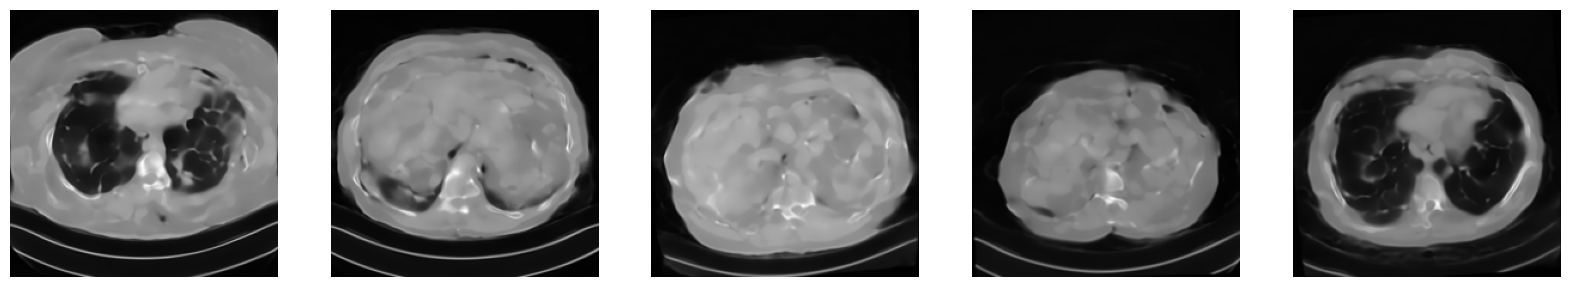

In [9]:
# Show the samples
plt.figure(figsize=(20, 4))
for i in range(samples.size(0)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(samples[i].reshape(-1, 224, 224).cpu().squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

## Guided samples

In [11]:
norm = "meanstd"
value_range = denormalize(torch.tensor([-1, 1]), mode=norm).cpu().detach().numpy()

NDTM_config = NDTMConfig(N=2, 
                         gamma_t= lambda t: 10 if t < 400 else 0.2 / (t/600), # torch.sigmoid((800 - t)/400) * 20.0, 
                         u_lr=0.002, 
                         w_terminal=2.0, 
                         u_lr_scheduler="linear",
                         w_vf_scheme="zero",
                         w_control_scheme="ones",
                         clip_images=True,
                         clip_range=value_range)

In [12]:
subject_model = BiomedClipSubjectModel(norm=norm).to(device)

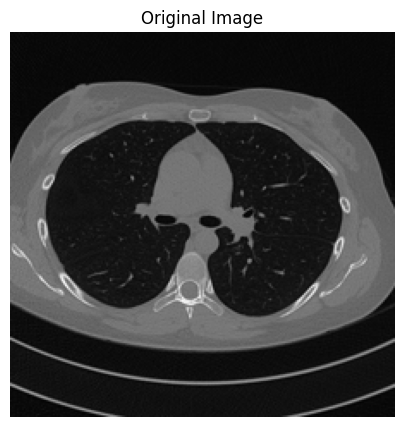

First 5 dimensions of BiomedClip embeddings: tensor([ 2.3668e-02, -1.3415e-02, -2.6287e-01, -4.5011e-02,  5.0259e-05],
       device='cuda:0')


In [13]:
from fff.data import load_dataset

data_set_config = {
    "name": "ldct",
    "root": "/mnt/SSD_2TB/ldct_data",
    "condition": "lowdose",
    "data": "highdose",
    "patchsize": 512,
    "resize_to": 224,
    "augment": False,
    "data_norm": norm,
}
_, val_ds, _ = load_dataset(**data_set_config)
test_image = val_ds[0][0].unsqueeze(0).to(device).reshape(1, 1, 224, 224)  # Get first image from validation set
with torch.no_grad():
    test_image_embedding = subject_model(test_image) # Apply the degredation model

plt.figure(figsize=(5, 5))
plt.imshow(test_image.squeeze().cpu().detach().numpy(), cmap="gray")
plt.axis('off')
plt.title("Original Image")
plt.show()
print(f"First 5 dimensions of BiomedClip embeddings: {test_image_embedding.squeeze()[:5]}")

In [29]:
ndtm = NDTM(
    generative_model=model,
    subject_model=subject_model,
    hparams=NDTM_config
)

In [30]:
img, _, _ = ndtm.sample(test_image.to(device), None, num_timesteps=100, y_0 = test_image_embedding.to(device))

Sampling:   0%|          | 0/100 [00:00<?, ?it/s]

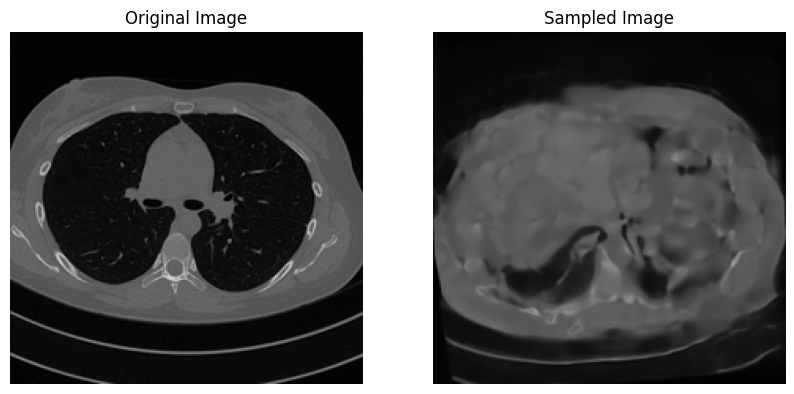

In [32]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image.squeeze().cpu().numpy(), cmap="gray", vmin=value_range[0], vmax=value_range[1])
plt.axis('off')
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(img.reshape(test_image.shape).squeeze().cpu().numpy(), cmap="gray", vmin=value_range[0], vmax=value_range[1])
plt.axis('off')
plt.title("Sampled Image")
plt.show()

# Conditional FM BiomedClip

## Unguided samples

In [8]:
model = FlowMatchingModel(load_fff_model(305))

/tmp/ipykernel_566292/4184309463.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location=torch.device("cpu"))  # Load on CPU
/hom

loading subject_model
cond_dim:  0
output_dim:  512
spatial size:  14
num_channels_pre_fc:  1024


In [9]:
norm = "meanstd"
value_range = denormalize(torch.tensor([-1, 1]), mode=norm).cpu().detach().numpy()

subject_model = BiomedClipSubjectModel(norm=norm).to(device)

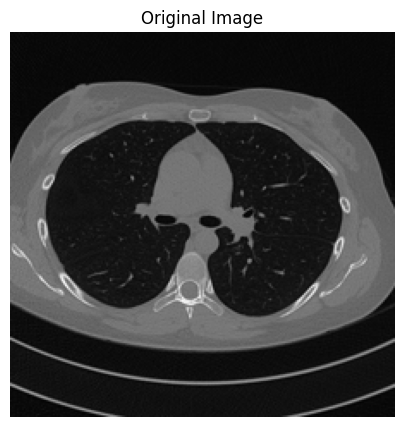

First 5 dimensions of BiomedClip embeddings: tensor([ 2.3668e-02, -1.3415e-02, -2.6287e-01, -4.5011e-02,  5.0259e-05],
       device='cuda:0')


In [10]:
from fff.data import load_dataset

data_set_config = {
    "name": "ldct",
    "root": "/mnt/SSD_2TB/ldct_data",
    "condition": "lowdose",
    "data": "highdose",
    "patchsize": 512,
    "resize_to": 224,
    "augment": False,
    "data_norm": norm,
}
_, val_ds, _ = load_dataset(**data_set_config)
test_image = val_ds[0][0].unsqueeze(0).to(device).reshape(1, 1, 224, 224)  # Get first image from validation set
with torch.no_grad():
    test_image_embedding = subject_model(test_image) # Apply the degredation model

plt.figure(figsize=(5, 5))
plt.imshow(test_image.squeeze().cpu().detach().numpy(), cmap="gray")
plt.axis('off')
plt.title("Original Image")
plt.show()
print(f"First 5 dimensions of BiomedClip embeddings: {test_image_embedding.squeeze()[:5]}")

In [13]:
samples = sample_fm(model, num_samples=5, num_timesteps=300, target_conditions=test_image_embedding.repeat(5,1))

Sampling:   0%|          | 0/300 [00:00<?, ?it/s]

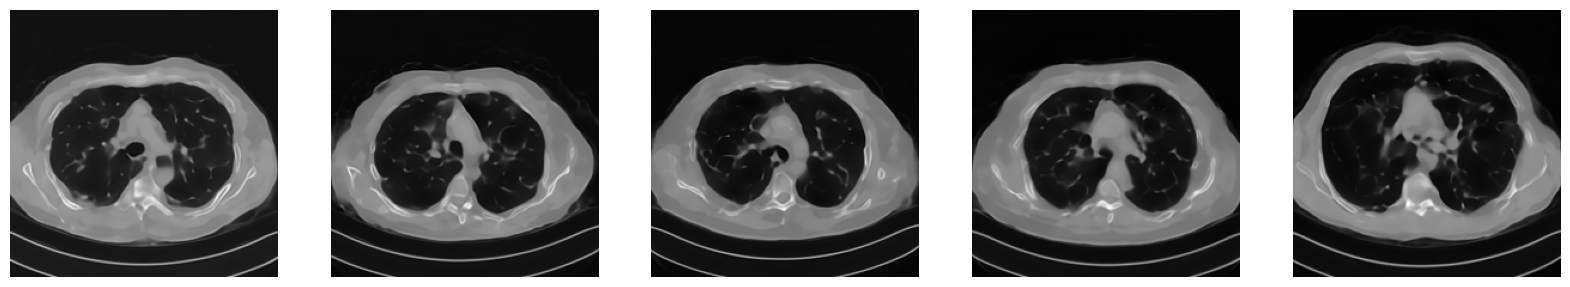

In [14]:
# Show the samples
plt.figure(figsize=(20, 4))
for i in range(samples.size(0)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(samples[i].reshape(-1, 224, 224).cpu().squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

## Guided samples

In [15]:
NDTM_config = NDTMConfig(N=2, 
                         gamma_t= lambda t: 10 if t < 400 else 0.2 / (t/600), # torch.sigmoid((800 - t)/400) * 20.0, 
                         u_lr=0.002, 
                         w_terminal=2.0, 
                         u_lr_scheduler="linear",
                         w_vf_scheme="zero",
                         w_control_scheme="ones",
                         clip_images=True,
                         clip_range=value_range)

In [16]:
ndtm = NDTM(
    generative_model=model,
    subject_model=subject_model,
    hparams=NDTM_config
)

In [18]:
img, _, _ = ndtm.sample(test_image.to(device), test_image_embedding, num_timesteps=100, y_0 = test_image_embedding.to(device))

Sampling:   0%|          | 0/100 [00:00<?, ?it/s]

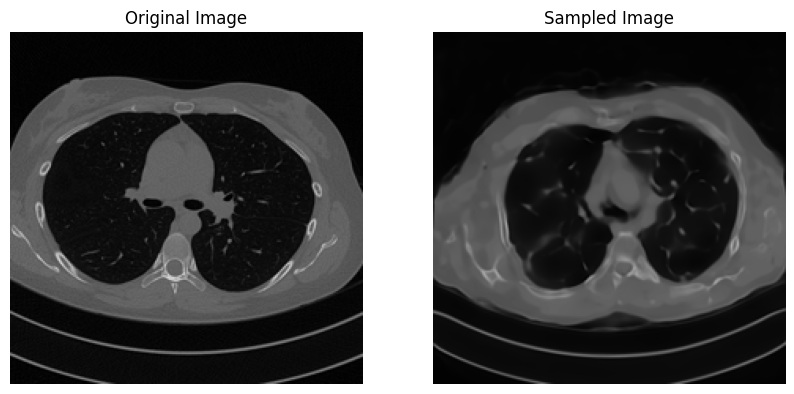

In [19]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image.squeeze().cpu().numpy(), cmap="gray", vmin=value_range[0], vmax=value_range[1])
plt.axis('off')
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(img.reshape(test_image.shape).squeeze().cpu().numpy(), cmap="gray", vmin=value_range[0], vmax=value_range[1])
plt.axis('off')
plt.title("Sampled Image")
plt.show()

# Fully Conditional Model BiomedClip

## Unguided samples

In [8]:
model = FlowMatchingModel(load_fff_model(270))

/tmp/ipykernel_566840/4184309463.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location=torch.device("cpu"))  # Load on CPU
/hom

loading subject_model


/home/armand/miniconda3/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


cond_dim:  0
output_dim:  512
spatial size:  14
num_channels_pre_fc:  1024
cond_dim:  0
output_dim:  512


In [9]:
norm = "meanstd"
value_range = denormalize(torch.tensor([-1, 1]), mode=norm).cpu().detach().numpy()

subject_model = BiomedClipSubjectModel(norm=norm).to(device)

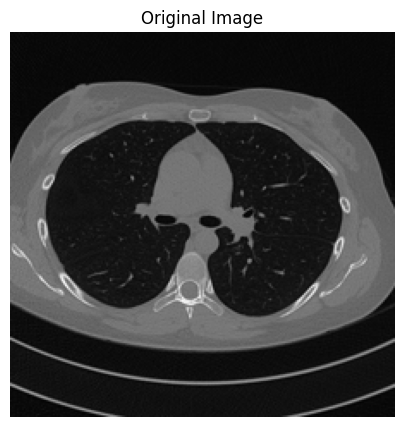

First 5 dimensions of BiomedClip embeddings: tensor([ 2.3668e-02, -1.3415e-02, -2.6287e-01, -4.5011e-02,  5.0259e-05],
       device='cuda:0')


In [10]:
from fff.data import load_dataset

data_set_config = {
    "name": "ldct",
    "root": "/mnt/SSD_2TB/ldct_data",
    "condition": "lowdose",
    "data": "highdose",
    "patchsize": 512,
    "resize_to": 224,
    "augment": False,
    "data_norm": norm,
}
_, val_ds, _ = load_dataset(**data_set_config)
test_image = val_ds[0][0].unsqueeze(0).to(device).reshape(1, 1, 224, 224)  # Get first image from validation set
with torch.no_grad():
    test_image_embedding = subject_model(test_image) # Apply the degredation model

plt.figure(figsize=(5, 5))
plt.imshow(test_image.squeeze().cpu().detach().numpy(), cmap="gray")
plt.axis('off')
plt.title("Original Image")
plt.show()
print(f"First 5 dimensions of BiomedClip embeddings: {test_image_embedding.squeeze()[:5]}")

In [11]:
samples = sample_fm(model, num_samples=5, num_timesteps=300, target_conditions=test_image_embedding.repeat(5,1))

Sampling:   0%|          | 0/300 [00:00<?, ?it/s]

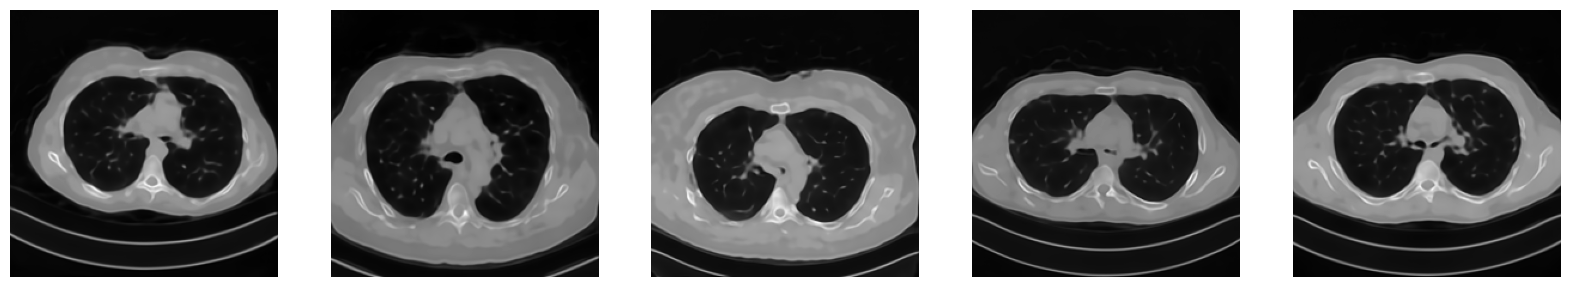

In [12]:
# Show the samples
plt.figure(figsize=(20, 4))
for i in range(samples.size(0)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(samples[i].reshape(-1, 224, 224).cpu().squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

## Guided samples

In [13]:
NDTM_config = NDTMConfig(N=2, 
                         gamma_t= lambda t: 10 if t < 400 else 0.2 / (t/600), # torch.sigmoid((800 - t)/400) * 20.0, 
                         u_lr=0.002, 
                         w_terminal=2.0, 
                         u_lr_scheduler="linear",
                         w_vf_scheme="zero",
                         w_control_scheme="ones",
                         clip_images=True,
                         clip_range=value_range)

In [14]:
ndtm = NDTM(
    generative_model=model,
    subject_model=subject_model,
    hparams=NDTM_config
)

In [15]:
img, _, _ = ndtm.sample(test_image.to(device), test_image_embedding, num_timesteps=100, y_0 = test_image_embedding.to(device))

Sampling:   0%|          | 0/100 [00:00<?, ?it/s]

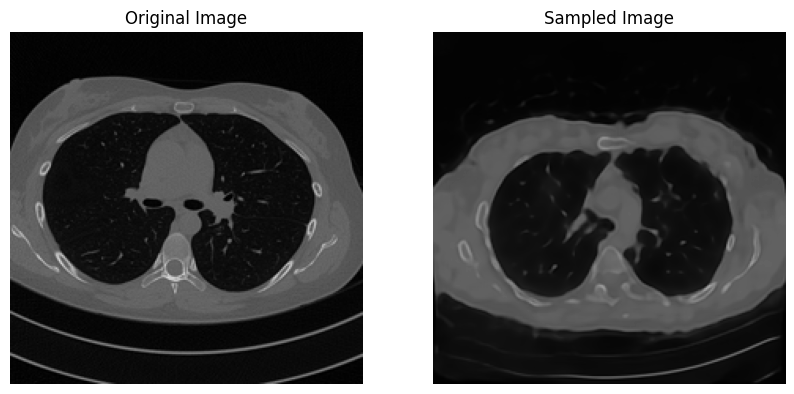

In [16]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image.squeeze().cpu().numpy(), cmap="gray", vmin=value_range[0], vmax=value_range[1])
plt.axis('off')
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(img.reshape(test_image.shape).squeeze().cpu().numpy(), cmap="gray", vmin=value_range[0], vmax=value_range[1])
plt.axis('off')
plt.title("Sampled Image")
plt.show()